In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [25]:
# Load the dataset
df = pd.read_csv("jamb_exam_results.csv")

# Standardize column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Identify columns with string (object) data types
string_columns = list(df.dtypes[df.dtypes == "object"].index)

# Convert string columns to lowercase and replace spaces with underscores
for c in string_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_", regex=True)

# Display the data types of the columns
df.dtypes

jamb_score                        int64
study_hours_per_week              int64
attendance_rate                   int64
teacher_quality                   int64
distance_to_school              float64
school_type                      object
school_location                  object
extra_tutorials                  object
access_to_learning_materials     object
parent_involvement               object
it_knowledge                     object
student_id                        int64
age                               int64
gender                           object
socioeconomic_status             object
parent_education_level           object
assignments_completed             int64
dtype: object

In [26]:
df.head().T

,0,1,2,3,4
jamb_score,192,207,182,210,199
study_hours_per_week,22,14,29,29,12
attendance_rate,78,88,87,99,98
teacher_quality,4,4,2,2,3
distance_to_school,12.4,2.7,9.6,2.6,8.8
school_type,public,public,public,public,public
school_location,urban,rural,rural,urban,urban
extra_tutorials,yes,no,yes,no,no
access_to_learning_materials,yes,yes,yes,yes,yes
parent_involvement,high,high,high,medium,medium


In [27]:
# Iterate through each column in the DataFrame to print information about the column
for column in df.columns:
    print(f"\nColumn: {column} | Data Type: {df[column].dtype}")

    # Print the number of unique values
    print(f"Number of Unique Values: {df[column].nunique()}")

    # Print the unique values, considering a limit to avoid overwhelming output
    unique_values = df[column].unique()
    if len(unique_values) <= 10:
        print(f"Unique Values: {unique_values}")
    else:
        print(f"Unique Values: {unique_values[:10]}... and more")


Column: jamb_score | Data Type: int64
Number of Unique Values: 220
Unique Values: [192 207 182 210 199 202 251 129 220 157]... and more

Column: study_hours_per_week | Data Type: int64
Number of Unique Values: 41
Unique Values: [22 14 29 12 25 35 27 23 15 32]... and more

Column: attendance_rate | Data Type: int64
Number of Unique Values: 51
Unique Values: [78 88 87 99 98 85 75 79 90 91]... and more

Column: teacher_quality | Data Type: int64
Number of Unique Values: 5
Unique Values: [4 2 3 1 5]

Column: distance_to_school | Data Type: float64
Number of Unique Values: 201
Unique Values: [12.4  2.7  9.6  2.6  8.8 13.6  9.4  4.6 15.6  4.5]... and more

Column: school_type | Data Type: object
Number of Unique Values: 2
Unique Values: ['public' 'private']

Column: school_location | Data Type: object
Number of Unique Values: 2
Unique Values: ['urban' 'rural']

Column: extra_tutorials | Data Type: object
Number of Unique Values: 2
Unique Values: ['yes' 'no']

Column: access_to_learning_mate

In [28]:
del df["student_id"]
df.head().T

,0,1,2,3,4
jamb_score,192,207,182,210,199
study_hours_per_week,22,14,29,29,12
attendance_rate,78,88,87,99,98
teacher_quality,4,4,2,2,3
distance_to_school,12.4,2.7,9.6,2.6,8.8
school_type,public,public,public,public,public
school_location,urban,rural,rural,urban,urban
extra_tutorials,yes,no,yes,no,no
access_to_learning_materials,yes,yes,yes,yes,yes
parent_involvement,high,high,high,medium,medium


In [29]:
df['parent_education_level'] = df['parent_education_level'].fillna(0)

# Calculate and print the number of missing values in each column
missing_values_summary = df.isnull().sum()
print(missing_values_summary)

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64


In [30]:
# Set the random state for reproducibility
random_state = 1

# Split the data into train and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

# Further split the full train set into train and validation sets
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)

# Check that the total number of rows is consistent
df.shape[0], df_train.shape[0] + df_test.shape[0] + df_val.shape[0]

# Reset the index for each dataset to maintain a clean index sequence
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target variable ('jamb_score') as numpy arrays for each dataset
y_full_train = df_full_train['jamb_score'].values
y_train = df_train['jamb_score'].values
y_val = df_val['jamb_score'].values
y_test = df_test['jamb_score'].values

# Remove the target variable from feature datasets to prepare for modeling
X_full_train = df_full_train.drop(columns=["jamb_score"])
X_train = df_train.drop(columns=["jamb_score"])
X_val = df_val.drop(columns=["jamb_score"])
X_test = df_test.drop(columns=["jamb_score"])

In [31]:
# Define the maximum depth of the decision tree to avoid overfitting
max_depth = 1

# Convert the training DataFrame to a list of dictionaries for vectorization
dicts = df_train.to_dict(orient="records")

# Initialize DictVectorizer to convert dictionaries to a feature matrix
dv = DictVectorizer(sparse=True)

# Transform the training data into a feature matrix
X = dv.fit_transform(dicts)

# Initialize the Decision Tree Regressor with the specified maximum depth
model = DecisionTreeRegressor(max_depth=max_depth)

# Train the decision tree model on the training data
model.fit(X, y_train)

# Rules of the trained decision tree
print(export_text(model, feature_names=dv.get_feature_names_out()))

|--- jamb_score <= 178.50
|   |--- value: [139.01]
|--- jamb_score >  178.50
|   |--- value: [218.03]



In [36]:
# Define the number of trees in the random forest
n_estimators = 10

# Set the random state for reproducibility
random_state = 1

# Set the number of jobs to run in parallel
n_jobs = -1

# Function to train a Random Forest model
def train_random_forest(df, y_train, n_estimators, random_state, n_jobs, max_depth=None):
    dicts = df.to_dict(orient="records")
    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        random_state=random_state, 
        max_depth=max_depth,
        n_jobs=n_jobs)
    model.fit(X_train, y_train)
    return dv, model

# Function to make predictions using the trained Random Forest model
def predict_random_forest(df, dv, model):
    dicts = df.to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict(X)
    return y_pred

# Train the Random Forest model and make predictions
dv, model = train_random_forest(df_train, y_train, n_estimators, random_state, n_jobs)
y_pred = predict_random_forest(df_val, dv, model)
y_pred
round(root_mean_squared_error(y_val, y_pred), 2)

np.float64(0.86)

In [12]:
random_state = 1
rmses = []
for n in range(10, 201, 10):
    dv, model = train_random_forest(df_train, y_train, n, random_state, n_jobs)
    y_pred = predict_random_forest(df_val, dv, model)
    y_pred
    rmse = round(root_mean_squared_error(y_val, y_pred), 3)
    rmses.append((n, rmse))

rmses

[(10, np.float64(42.137)),
 (20, np.float64(41.461)),
 (30, np.float64(41.106)),
 (40, np.float64(40.917)),
 (50, np.float64(40.852)),
 (60, np.float64(40.784)),
 (70, np.float64(40.677)),
 (80, np.float64(40.539)),
 (90, np.float64(40.504)),
 (100, np.float64(40.517)),
 (110, np.float64(40.593)),
 (120, np.float64(40.625)),
 (130, np.float64(40.651)),
 (140, np.float64(40.595)),
 (150, np.float64(40.597)),
 (160, np.float64(40.604)),
 (170, np.float64(40.628)),
 (180, np.float64(40.641)),
 (190, np.float64(40.631)),
 (200, np.float64(40.601))]

In [13]:
df_rmse = pd.DataFrame(rmses, columns=["n_estimators", "rmse"])
df_rmse

,n_estimators,rmse
0,10,42.137
1,20,41.461
2,30,41.106
3,40,40.917
4,50,40.852
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517


In [14]:
idmin = df_rmse.rmse.idxmin()
min_rmse_n = df_rmse.iloc[idmin].n_estimators
min_rmse = round(df_rmse.iloc[idmin].rmse, 3)
min_rmse_n

np.float64(90.0)

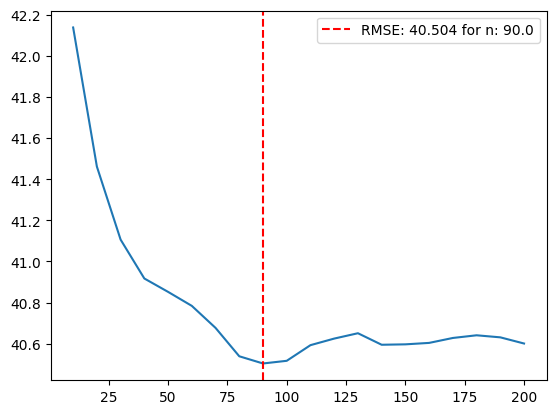

In [15]:
plt.plot(df_rmse.n_estimators, df_rmse.rmse)
plt.axvline(x=min_rmse_n, color='red', linestyle="--", label=f"RMSE: {min_rmse} for n: {min_rmse_n}")
plt.legend()

In [16]:
n_jobs = -1
random_state = 1
depths = [10, 15, 20, 25]
n_estimators = range(10, 201, 10)
rmses = []
mean_rmse_per_depth = []
for max_depth in depths:        
    rmse_for_depth = []
    for n in n_estimators:        
        dv, model = train_random_forest(
            df_train, 
            y_train, 
            n_estimators=n, 
            random_state=random_state, 
            n_jobs=n_jobs, 
            max_depth=max_depth
        )
        y_pred = predict_random_forest(df_val, dv, model)
        y_pred
        rmse = root_mean_squared_error(y_val, y_pred)
        rmses.append((n, max_depth, rmse))
        rmse_for_depth.append(rmse)

    mean_rmse = np.mean(rmse_for_depth)
    mean_rmse_per_depth.append((max_depth, mean_rmse))

rmses

[(10, 10, np.float64(41.258348648352545)),
 (20, 10, np.float64(40.88052845942386)),
 (30, 10, np.float64(40.62495594199098)),
 (40, 10, np.float64(40.270069249393075)),
 (50, 10, np.float64(40.31700620909737)),
 (60, 10, np.float64(40.27703523312143)),
 (70, 10, np.float64(40.285211180892674)),
 (80, 10, np.float64(40.21030547138022)),
 (90, 10, np.float64(40.17389971253662)),
 (100, 10, np.float64(40.25049014290326)),
 (110, 10, np.float64(40.286316340858086)),
 (120, 10, np.float64(40.31532362946843)),
 (130, 10, np.float64(40.32896060681657)),
 (140, 10, np.float64(40.29975736944223)),
 (150, 10, np.float64(40.314326720921464)),
 (160, 10, np.float64(40.354350211250896)),
 (170, 10, np.float64(40.36008523133161)),
 (180, 10, np.float64(40.36419635538415)),
 (190, 10, np.float64(40.35378105367313)),
 (200, 10, np.float64(40.32501201024063)),
 (10, 15, np.float64(42.00397868031699)),
 (20, 15, np.float64(41.45569853039702)),
 (30, 15, np.float64(41.16757778438639)),
 (40, 15, np.floa

In [17]:
mean_rmse_per_depth

[(10, np.float64(40.39249798892396)),
 (15, np.float64(40.73528172486332)),
 (20, np.float64(40.739734321829275)),
 (25, np.float64(40.78786565962805))]

In [18]:
df_rmse_with_depth = pd.DataFrame(rmses, columns=["n_estimators", "depth", "rmse"])
df_rmse_with_depth

,n_estimators,depth,rmse
0,10,10,41.258349
1,20,10,40.880528
2,30,10,40.624956
3,40,10,40.270069
4,50,10,40.317006
...,...,...,...
75,160,25,40.600208
76,170,25,40.624371
77,180,25,40.638564
78,190,25,40.628661


In [19]:
df_pivotal = pd.pivot(
    df_rmse_with_depth,
    columns="depth",
    index=["n_estimators"], 
    values=["rmse"]
)
df_pivotal

rmse                                 
depth                10         15         20         25
n_estimators                                            
10            41.258349  42.003979  42.024831  42.160439
20            40.880528  41.455699  41.388831  41.470970
30            40.624956  41.167578  41.116326  41.125193
40            40.270069  40.930593  40.847429  40.933939
50            40.317006  40.782970  40.808710  40.866871
60            40.277035  40.724170  40.784463  40.796605
70            40.285211  40.689415  40.653663  40.687163
80            40.210305  40.533749  40.515399  40.548492
90            40.173900  40.496685  40.493177  40.512574
100           40.250490  40.504812  40.517604  40.522283
110           40.286316  40.530819  40.572731  40.591911
120           40.315324  40.580236  40.589681  40.619898
130           40.328961  40.557808  40.589177  40.646433
140           40.299757  40.520364  40.536444  40.591027
150           40.314327  40.529308  40.537381  40.593185
160           40.354350  40.523299  40.550345  40.600208
170           40.360085  40.533787  40.564237  40.624371
180           40.364196  40.546689  40.574707  40.638564
190           40.353781  40.550057  40.581853  40.628661
200           40.325012  40.543618  40.547698  40.598527

In [20]:
mean_rmse_per_depth = df_pivotal.mean(axis=0).round(3)
mean_rmse_per_depth

      depth
rmse  10       40.392
      15       40.735
      20       40.740
      25       40.788
dtype: float64

<Axes: xlabel='None-depth', ylabel='n_estimators'>

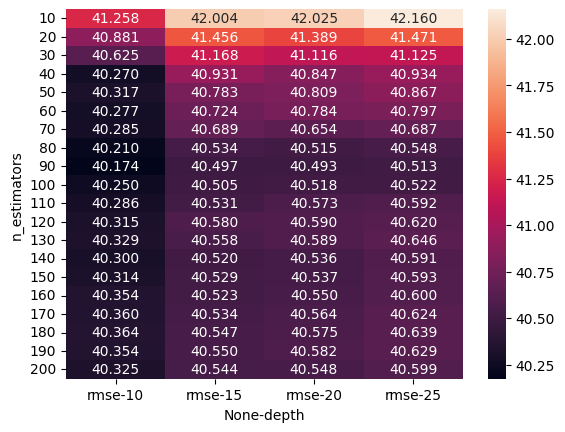

In [21]:
sns.heatmap(df_pivotal, annot=True, fmt=".3f")

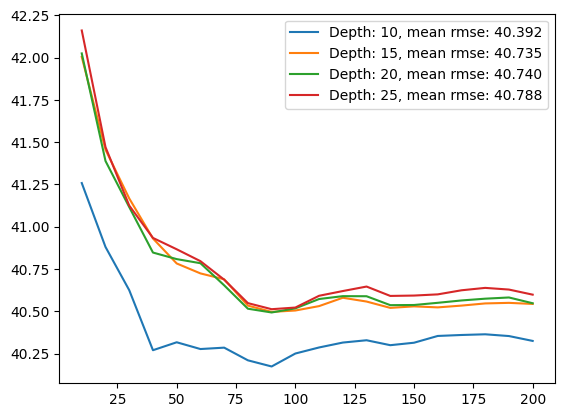

In [22]:
for d in depths:    
    df_subset = df_rmse_with_depth[df_rmse_with_depth.depth == d]
    mean_rmse = df_subset.rmse.mean()
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f"Depth: {d}, mean rmse: {mean_rmse:.3f}")
plt.legend()

In [23]:
n_estimators = 10
max_depth = 20
random_state = 1
n_jobs = -1

dv, forest = train_random_forest(
    df_train, 
    y_train, 
    n_estimators=n_estimators,     
    random_state=random_state, 
    n_jobs=n_jobs,
    max_depth=max_depth
)

y_pred = predict_random_forest(df_val, dv, model)
y_pred
round(root_mean_squared_error(y_val, y_pred), 2)

np.float64(40.6)

Elapsed time to compute the importances: 0.017 seconds


study_hours_per_week                0.248354
attendance_rate                     0.149729
distance_to_school                  0.136486
teacher_quality                     0.082682
age                                 0.069311
assignments_completed               0.031517
socioeconomic_status=high           0.025714
parent_involvement=high             0.022919
it_knowledge=high                   0.017719
parent_education_level=secondary    0.016957
parent_education_level=primary      0.015450
parent_education_level=tertiary     0.014489
extra_tutorials=no                  0.013459
parent_involvement=low              0.013358
it_knowledge=low                    0.012404
access_to_learning_materials=no     0.012325
parent_involvement=medium           0.011492
socioeconomic_status=low            0.010708
socioeconomic_status=medium         0.010563
gender=male                         0.010383
access_to_learning_materials=yes    0.010262
school_location=rural               0.009559
gender=fem

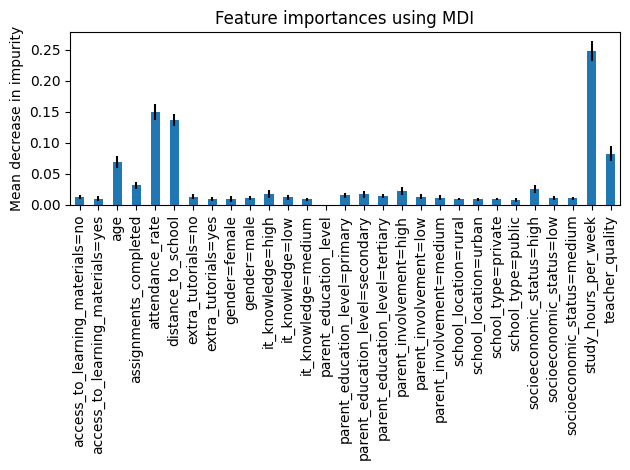

In [24]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

import pandas as pd
feature_names = list(dv.get_feature_names_out())
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

forest_importances.sort_values(ascending=False)

In [25]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 59.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 45.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [35]:
xgb.train?

Signature:
xgb.train(
    params: Dict[str, Any],
    dtrain: xgboost.core.DMatrix,
    num_boost_round: int = 10,
    *,
    evals: Optional[Sequence[Tuple[xgboost.core.DMatrix, str]]] = None,
    obj: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[numpy.ndarray, numpy.ndarray]]] = None,
    feval: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]] = None,
    maximize: Optional[bool] = None,
    early_stopping_rounds: Optional[int] = None,
    evals_result: Optional[Dict[str, Dict[str, Union[List[float], List[Tuple[float, float]]]]]] = None,
    verbose_eval: Union[bool, int, NoneType] = True,
    xgb_model: Union[str, os.PathLike, xgboost.core.Booster, bytearray, NoneType] = None,
    callbacks: Optional[Sequence[xgboost.callback.TrainingCallback]] = None,
    custom_metric: Optional[Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]] = None,
) -> xgboost.core.Booster
Docstring:
Train a booster with given parameters.

Paramet

In [36]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(dicts)
val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

feature_names=list(dv.get_feature_names_out())

dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, y_val, feature_names=feature_names)

def train_xgb(dtrain, dval, evals_result, eta=0.3, num_boost_round=100):
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    watchlist = [(dtrain, "train"), (dval, "val")]

    model = xgb.train(
        xgb_params, 
        dtrain, 
        evals=watchlist, 
        evals_result=evals_result,
        num_boost_round=num_boost_round,
        verbose_eval=False
    )
    return model

In [37]:
def get_xgb_best_rmse(dtrain, dval, eta):
    evals_result = {}
    model = train_xgb(dtrain=dtrain, dval=dval, evals_result=evals_result, eta=eta)    

    df_score = pd.DataFrame()
    df_score["train"] = evals_result["train"]["rmse"]
    df_score["val"] = evals_result["val"]["rmse"]

    idx_min = df_score["val"].idxmin()
    min_rmse = df_score.iloc[idx_min]["val"].round(3)    

    mean_rmse = df_score["val"].mean().round(3)    

    y_pred = model.predict(dval)
    best_rmse = round(root_mean_squared_error(y_val, y_pred), 3)    

    return min_rmse, mean_rmse, best_rmse

min_rmse, mean_rmse, best_rmse = get_xgb_best_rmse(dtrain, dval, 0.3)
print(f"Eta: 0.3, rmse: min {min_rmse}, mean {mean_rmse}, best: {best_rmse}")

min_rmse, mean_rmse, best_rmse = get_xgb_best_rmse(dtrain, dval, 0.1)
print(f"Eta: 0.1, rmse: min {min_rmse}, mean {mean_rmse}, best: {best_rmse}")

Eta: 0.3, rmse: min 40.651, mean 42.963, best: 44.432
Eta: 0.1, rmse: min 40.111, mean 40.894, best: 41.043


Min rmse 40.111 for eta: 0.1
Mean rmse 40.894 for eta: 0.1
Best rmse 41.043 for eta: 0.1
Min rmse 40.651 for eta: 0.3
Mean rmse 42.963 for eta: 0.3
Best rmse 44.432 for eta: 0.3


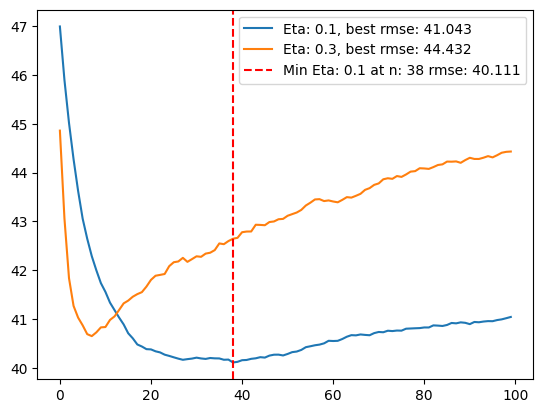

In [38]:
idx_min_final = None
rmse_min_final = None
eta_min_final = None

for eta in [0.1, 0.3]:
    evals_result = {}
    model = train_xgb(dtrain=dtrain, dval=dval, evals_result=evals_result, eta=eta)
    df_score = pd.DataFrame()
    df_score["train"] = evals_result["train"]["rmse"]
    df_score["val"] = evals_result["val"]["rmse"]

    idx_min = df_score["val"].idxmin()
    rmse_min = df_score.iloc[idx_min]["val"].round(3)
    print(f"Min rmse {rmse_min} for eta: {eta}")

    mean_rmse = df_score["val"].mean().round(3)
    print(f"Mean rmse {mean_rmse} for eta: {eta}")

    y_pred = model.predict(dval)
    best_rmse = round(root_mean_squared_error(y_val, y_pred), 3)
    print(f"Best rmse {best_rmse} for eta: {eta}")

    if rmse_min_final is None or rmse_min < rmse_min_final:
        idx_min_final = idx_min
        rmse_min_final = rmse_min
        eta_min_final = eta    
    plt.plot(df_score.index, df_score.val, label=f"Eta: {eta}, best rmse: {best_rmse:.3f}")

plt.axvline(
    x=idx_min_final,
    color="red",
    linestyle="--",
    label=f"Min Eta: {eta_min_final} at n: {idx_min_final} rmse: {rmse_min_final}",
)

plt.legend()
